In [1]:
#Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Measurement Data Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get a list of column names and types
inspector = inspect(engine)

m_columns = inspector.get_columns('Measurement')
print("Measurement")
for c in m_columns:
    print(c['name'], c["type"])

s_columns = inspector.get_columns('Station')
print("Station")
for c in s_columns:
    print(c['name'], c["type"])


Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# View of Measurement Data
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()                     
               

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# View of Station Data
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [14]:
# Calculate the date 1 year ago from the last data point in the database
# Last Date
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last day is: {last_day[0]}")

year_ago = (dt.datetime.strptime(last_day[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"Date one year ago is: {year_ago}")

Last day is: 2017-08-23
Date one year ago is: 2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
p_scores = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= year_ago).\
order_by(Measurement.date).all()
p_scores [: 5]

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02)]

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precp_df = pd.DataFrame(p_scores, columns=['date', 'precipitation']).dropna()

#Set the index
precp_df.set_index('date',inplace=True)
precp_df = precp_df.sort_index()

precp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


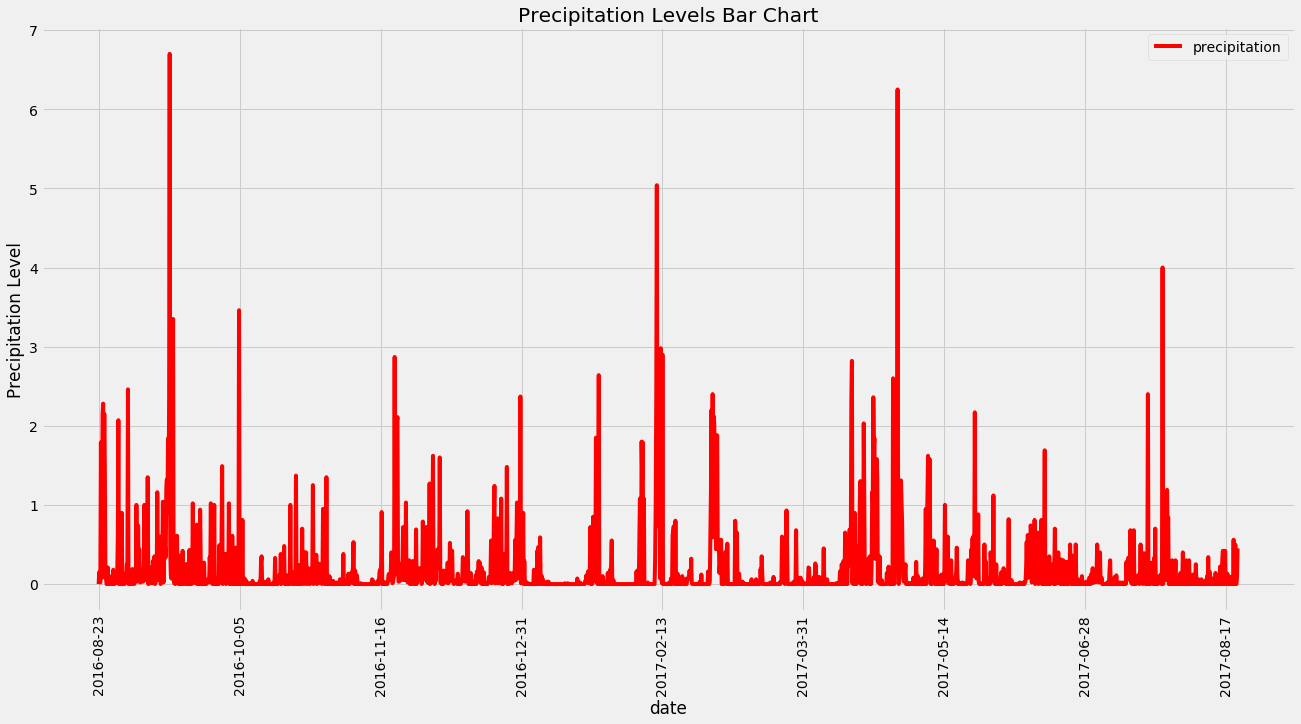

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
plot = precp_df.plot(rot=90, color="r", figsize=(20,10))
plot.set_title("Precipitation Levels Bar Chart")
plot.set_ylabel("Precipitation Level")

#Save image
plt.savefig("./images/precipitation")

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Station Data Analysis

In [19]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).group_by(Station.station).count()
station_count

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.date)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).all()

most_active_stations [: 10]

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id (most active station) from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [Measurement.station, 
       func.max(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs)]

stats = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()

stats_df = pd.DataFrame(stats, columns=['Station', 'Max_Temp', 'Min_Temp', 'Mean_Temp'])
stats_df

,Station,Max_Temp,Min_Temp,Mean_Temp
0,USC00519281,85.0,54.0,71.663781


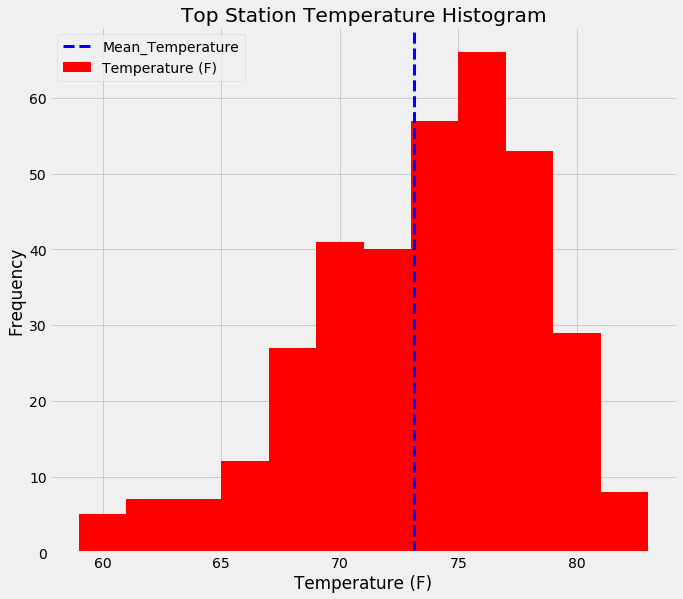

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [Measurement.station,
       Measurement.tobs]

high_temp = session.query(*sel).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.date).\
    order_by(Measurement.date.asc()).all()
    
#Setup to dataframe
high_temp_df = pd.DataFrame(high_temp, columns=['Date', 'Temp'])
high_temp_df.set_index('Date', inplace=True)
    
#Histogram plot of temperatures
plt.figure(figsize=(10,9))
plt.hist(high_temp_df['Temp'], 12, density=False, label="Temperature (F)", color="r")

#Setup labels
plt.axvline(high_temp_df['Temp'].mean(), color='b', linestyle='dashed', linewidth=3, label="Mean_Temperature")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Top Station Temperature Histogram")


#Save image
plt.savefig("./images/station-histogram")

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = '2017-07-15'
end_date = '2017-07-23'
stats_results = calc_temps(start_date,end_date)[0]
stats_df = pd.DataFrame(stats_results, columns=[("Min_Temp", "Mean_Temp", "Max_Temp")]).set_index
stats_df

<bound method DataFrame.set_index of    (MIN_Temp, Mean_Temp, Max_Temp)
0                        72.000000
1                        78.589286
2                        83.000000>

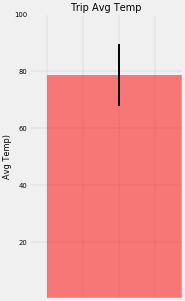

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_axis = [0]
y_axis = [stats_results[1]]
error = [(stats_results[2] - stats_results[0])]

plt.figure(figsize=(5, 10), dpi=35)
plt.bar(x_axis,y_axis,yerr=error,color='r',alpha=.5,align='edge')
plt.xlim(-0.1,0.75)
plt.ylim(0.5, 100)
plt.ylabel("Avg Temp)")
plt.title("Trip Avg Temp")
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(y_axis,linestyle='')
plt.grid(x_axis,linestyle='-')

#Save image
plt.savefig("./images/trip_avg_temp")

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2016-07-15'
end_date = '2016-07-23'

sel = [func.count(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation]
rainfall=session.query(*sel).filter(Measurement.station==Station.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    order_by(func.count(Measurement.prcp).desc()).all()
for r in rainfall:
    print(r)

(9, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(9, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(9, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(7, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(6, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(5, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(1, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-07-15'
end_date = '2017-07-23'

# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).group_by(Measurement.date).all()

# List comprehension to get the elements in the tuple from the dates query 
trip_dates = [x[0] for x in dates]

# Stip off the year and save a list of %m-%d strings with another list comprehension 
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

# Stip off the year and save a list of %m-%d strings
trip_dates_stripped= [x[5:] for x in trip_dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).\
                 filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).\
                 filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).\
                 group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals_df = daily_normals[0]
print("Aggregate Daily Normals for 07-15-2017 to 07-23-2017")
daily_normals_df

Aggregate Daily Normals for 07-15-2017 to 07-23-2017


[(68.0, 76.2542372881356, 82.0),
 (70.0, 76.34482758620689, 83.0),
 (70.0, 76.30188679245283, 83.0),
 (72.0, 76.63793103448276, 83.0),
 (68.0, 75.89090909090909, 83.0),
 (69.0, 75.46296296296296, 82.0),
 (69.0, 76.9245283018868, 83.0),
 (69.0, 75.78846153846153, 81.0),
 (70.0, 76.20370370370371, 84.0)]

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(daily_normals_df, index=trip_dates, columns = ['T Min' , 'T Avg', 'T Max']) 
normals_df.index.name = "Dates"
normals_df

,T Min,T Avg,T Max
Dates,,,
2017-07-15,68.0,76.254237,82.0
2017-07-16,70.0,76.344828,83.0
2017-07-17,70.0,76.301887,83.0
2017-07-18,72.0,76.637931,83.0
2017-07-19,68.0,75.890909,83.0
2017-07-20,69.0,75.462963,82.0
2017-07-21,69.0,76.924528,83.0
2017-07-22,69.0,75.788462,81.0
2017-07-23,70.0,76.203704,84.0


<Figure size 1440x1080 with 0 Axes>

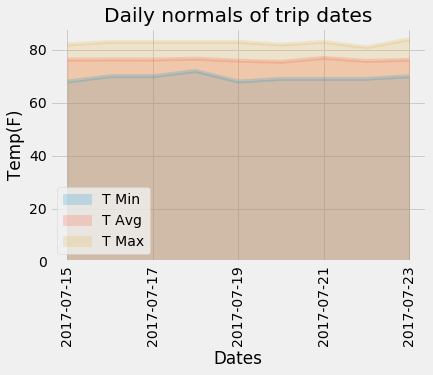

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure(figsize = (20,15))
normals_df.plot.area(stacked = False, alpha = 0.2)
plt.xticks(rotation = 90)
plt.title("Daily normals of trip dates")
plt.ylabel("Temp(F)")
plt.xlabel("Dates")
plt.savefig("./images/daily normals")